# DivExplorer analysis - Example with COMPAS dataset 

This notebook shows an example of the use of DivExplorer.

# Import dataset

In this running example we analyze the [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset.

We import an already pre-processed and discretized version. You can refer to this [notebook](www.google.com) for its pre-processing.

The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- *age_cat*: age category of the defendant. 
- *c_charge_degree*: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- *race*: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- *sex*: 'Female', 'Male'
- *length_of_stay*: the days spent in jail, derived from the records of the date in which the person entered lastly the jail and the date in which the person was released.
- *priors_count*: the number of prior crimes committed.


For each defendant, the dataset also records:
- the *class*, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the *predicted* recidivism, derived from the COMPAS score of recidivism risk assesses the defendant’s likelihood of committing another offense in a period of two years. It is 1 if the risk is high.

In [1]:
import os
inputDir=os.path.join(".", "datasets")

import pandas as pd
df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
class_map={'N': 0, 'P': 1}
df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


# Compute pattern divergence

With DivExplorer, we can compute the the performance metrics and the divergence scores of *all* itemsets whose frequency in the dataset is above a minimum frequency threshold (min_sup).

To compute the divergence score, we have to specify the following info.

FP_DivergenceExplorer:
- **df**: discretized dataset (DataFrame)
- true_class_name: name of the **class** column (str)
- predicted_class_name: name of the **predicted** class column (str)
- dictionary indicating the positive and the negative class (dict)  {'N': 0, 'P': 1}.

getFrequentPatternDivergence methods:
- min_sup: the minimum frequency threshold
- metrics: divergence metrics of interest. In the example we specify the false positive (d_fpr), false negative (d_fnr) and accuracy divergence (d_accuracy) (also the default ones)


As output we obtain a dataframe. Each row contain the information of a frequent pattern (with a support greater or equal to min_sup) and the divergence scores.

In [2]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer

min_sup=0.1
fp_diver=FP_DivergenceExplorer(df, true_class_name = "class", predicted_class_name = "predicted", class_map=class_map)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_fpr", "d_fnr", "d_accuracy"])

In [3]:
print(f"Number of frequent patterns: {len(FP_fm)}")

Number of frequent patterns: 155


DivExplorer computes the divergences for all itemsets above the specified support size.

Specifically, each row of the obtained dataframe has the following information:
- itemset
- support of the itemset
- support count
- TP, TN, FP, FN: the number of true positive (TP), true negatives (TP), false positives (FP) and false negatives (FN) of the itemset. The colulms hence represent the confusion matrix of the itemset
- length of the itemset: number of items in an itemset
- Performance measure: in the example we have the false positive rate (fpr), false negative rate (fnr) and accuracy.
- **Divergence**: the divergence of the itemset with respect the metric(s) of interest. In the example, we have the false positive rate divergence (**d_fpr**), false negative divergence (**d_fnr**) and the accuracy divergence (**d_acc**)

In [4]:
FP_fm.head()

,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,fnr,d_fnr,accuracy,d_accuracy,t_value_fp,t_value_fn,t_value_tp_tn
0,1.000000,(),3066.0,297.0,1962.0,847.0,0,6172.0,0.088314,0.000000,0.698469,0.000000,0.633992,0.000000,0.000000,0.000000,0.000000
1,0.809624,(sex=Male),2357.0,244.0,1647.0,749.0,1,4997.0,0.093810,0.005496,0.687396,-0.011074,0.621573,-0.012419,0.738697,0.864525,1.350598
2,0.772683,(stay=<week),2589.0,201.0,1487.0,492.0,1,4769.0,0.072043,-0.016271,0.751390,0.052920,0.646047,0.012055,2.339352,4.059364,1.301787
3,0.643227,(charge=F),1772.0,214.0,1307.0,677.0,1,3970.0,0.107754,0.019440,0.658770,-0.039699,0.616877,-0.017116,2.301183,2.896145,1.738770
4,0.614226,"(sex=Male, stay=<week)",1959.0,162.0,1236.0,434.0,2,3791.0,0.076379,-0.011935,0.740120,0.041651,0.631232,-0.002760,1.555571,3.011311,0.280104


DivExplorer compute the divergence scores with respect to multiple metrics. 

We can then analyze the divergence values for a specific performance measure on interest.

# Analyze FPR divergence

Let's start by analyzing the false positive rate divergence.

In [5]:
from divexplorer.FP_Divergence import FP_Divergence
fp_divergence_fpr=FP_Divergence(FP_fm, "d_fpr")

In [6]:
INFO_VIZ=["support", "itemsets",  fp_divergence_fpr.metric, fp_divergence_fpr.t_value_col]

## Top-K FPR divergence

We can first analyze the top K (K=10) most divergent patterns, the ones with highest FPR.


The itemset that has greatest divergence is {age=25-45, #prior>3, race=Afr-Am, sex=Male}, with support 13% of the dataset (0.128645), and false-positive divergence 0.220 (0.219722). 

Male African-American defendants between 25 and 45 years of age, with more than 3 prior offenses, are wrongly predicated to recidivate at a rate 0.220 (or 22%) greater than the average defendant.

In [7]:
K=10
fp_divergence_fpr.getDivergence(th_redundancy=0)[INFO_VIZ].head(K)

,support,itemsets,d_fpr,t_value_fp
112,0.128645,"(age=25-45, race=Afr-Am, sex=Male, #prior=>3)",0.219722,7.116857
92,0.145010,"(age=25-45, race=Afr-Am, #prior=>3)",0.210928,7.448260
135,0.109527,"(age=25-45, race=Afr-Am, #prior=>3, charge=F)",0.201841,6.201585
109,0.130752,"(race=Afr-Am, sex=Male, #prior=>3, charge=F)",0.180408,6.132988
67,0.175308,"(race=Afr-Am, sex=Male, #prior=>3)",0.178557,7.214382
55,0.196695,"(race=Afr-Am, #prior=>3)",0.172783,7.582039
87,0.148412,"(race=Afr-Am, #prior=>3, charge=F)",0.170810,6.421341
105,0.133668,"(age=25-45, sex=Male, #prior=>3, charge=F)",0.170019,6.011738
82,0.155865,"(age=25-45, #prior=>3, charge=F)",0.167741,6.491614
62,0.180655,"(age=25-45, sex=Male, #prior=>3)",0.164627,6.903692


## Shapley value

We can be interest in analyzing the influence of each individual item (i.e. attribute value pair) to the divergence.

In [8]:
# Itemset with highest divergence
top1_itemset_divergence_fpr=fp_divergence_fpr.getDivergenceTopK(K=1, th_redundancy=0)
top1_itemset_fpr=list(top1_itemset_divergence_fpr)[0]
top1_itemset_divergence_fpr

{frozenset({'#prior=>3',
            'age=25-45',
            'race=Afr-Am',
            'sex=Male'}): 0.21972170893335036}

DivExplorer use the notion of Shapley value to estimate the contribution of each item to the divergence

In [9]:
itemset_shapley_value=fp_divergence_fpr.computeShapleyValue(top1_itemset_fpr)


We plot the Shapley Values. 

Most of the divergence of this itemset (most of the excess false-positive rate) is due to having more than 3 prior offenses, with race=Afr-Am as the second most important
factor.

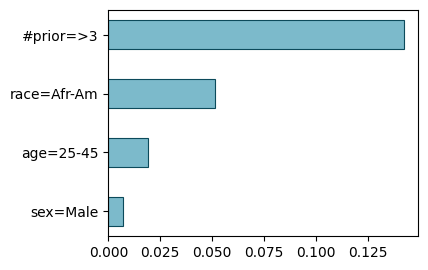

In [10]:
fp_divergence_fpr.plotShapleyValue(shapley_values=itemset_shapley_value)

## Lattice

We can visualize the lattice graph of a specific itemset.

In the example we analyze again the most divergence pattern.

We can specify a threshold of divergence of interest *Th_divergence*. The itemsets with divergence greater than *Th_divergence* are highlighted with a different color.

In [11]:
fig=fp_divergence_fpr.plotLatticeItemset(top1_itemset_fpr, Th_divergence=0.15, sizeDot="small")
#fig.show()

## Summarization

Many of the most divergent itemsets are quite similar.

We can summarize the frequent pattern diverenge using the DivExplorer pruning.

We have to specify a redundancy threshold *th_redundancy*. If two itemsets I and I ∪ {A} have divergences closer than ε, only the smaller itemset I is kept.

In [12]:
eps=0.01
K=10
fp_divergence_fpr.getDivergence(th_redundancy=eps)[INFO_VIZ].head(K)

,support,itemsets,d_fpr,t_value_fp
92,0.145010,"(age=25-45, race=Afr-Am, #prior=>3)",0.210928,7.448260
55,0.196695,"(race=Afr-Am, #prior=>3)",0.172783,7.582039
49,0.207226,"(age=25-45, #prior=>3)",0.163575,7.384973
110,0.129780,"(race=Afr-Am, stay=<week, #prior=>3)",0.140468,5.486527
141,0.107583,"(race=Afr-Am, sex=Male, age=<25)",0.131095,4.886362
28,0.293422,(#prior=>3),0.130955,7.503321
94,0.142417,"(age=25-45, stay=<week, #prior=>3)",0.124015,5.155533
108,0.131076,"(race=Afr-Am, age=<25)",0.119233,5.200687
80,0.156837,"(age=<25, charge=F)",0.115160,5.643205
56,0.194426,"(stay=<week, #prior=>3)",0.101941,5.283437


The number of itemsets goes from 155 to 55.

In [13]:
len(fp_divergence_fpr.getDivergence(th_redundancy=0)), len(fp_divergence_fpr.getDivergence(th_redundancy=eps))

(155, 55)

## Corrective phenomena

DivExplorer allows to identify peculiar behaviors as corrective phenomena.

*Corrective items* are items that, when added to an itemset, *reduce* the divergence. 

Given an itemset $I$ and an item $i \not\in I$, we say that $i$ is a *corrective item* for $I$ if 
$|\Delta(I \cup i)|<|\Delta(I)|$. The difference between the two terms ($|\Delta(I)| - |\Delta(I \cup i)|$) is defined as *corrective factor* (corr_factor).





Consider the first row.
The divergence of the itemset {*race=Afr-Am, sex=Male*} is 0.06 (v_S). When the item #prior=0 is included, the divergence drops to is almost 0 (0.009, v_S+i).

In [14]:
corrSign=fp_divergence_fpr.getCorrectiveItems()
corrSign.head(5)

,item i,S,S+i,v_i,v_S,v_S+i,t_value_corr,corr_factor
289,(#prior=0),"(race=Afr-Am, sex=Male)","(#prior=0, sex=Male, race=Afr-Am)",-0.039927,0.062371,0.009430,2.823776,0.052941
96,(#prior=0),(race=Afr-Am),"(#prior=0, race=Afr-Am)",-0.039927,0.051052,-0.000500,3.376132,0.050552
260,(race=Afr-Am),"(#prior=0, stay=<week)","(#prior=0, race=Afr-Am, stay=<week)",0.051052,-0.043788,-0.003043,3.070673,0.040746
97,(race=Afr-Am),(#prior=0),"(#prior=0, race=Afr-Am)",0.051052,-0.039927,-0.000500,3.035485,0.039427
378,"(#prior=[1,3])","(sex=Male, race=Afr-Am, stay=<week)","(race=Afr-Am, sex=Male, stay=<week, #prior=[1,3])",-0.015258,0.037486,-0.001609,2.005249,0.035877


### Lattice of corrective phenomena

We can inspect the corrective phenomena also with the lattice graph.

If getLower is set to True, the itemset when a corrective behavior is observed are highlighted with a different color.

In [15]:
itemset_corrective=corrSign.head(1)["S+i"].values[0]
fig=fp_divergence_fpr.plotLatticeItemset(itemset_corrective, Th_divergence=0.05, sizeDot="small", getLower=True)
#fig.show()

### Shapley value of corrective phenomena

We can observe the corrective phenomena also with the Shapley values.

The number of prior equal to 0 has a negative contribution to the divergence.

In [16]:
item_corrective,itemset_corrective=corrSign.head(1)[["S","S+i"]].values[0]

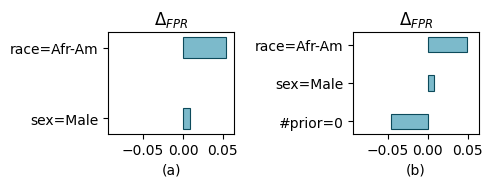

In [17]:
from divexplorer.shapley_value_FPx import plotComparisonShapleyValues

item_corrective,itemset_corrective=corrSign.head(1)[["S","S+i"]].values[0]

shap_item_corrective=fp_divergence_fpr.computeShapleyValue(item_corrective)
shap_itemset_corrective=fp_divergence_fpr.computeShapleyValue(itemset_corrective)
t1, t2=[f"$Δ_{{{fp_divergence_fpr.metric_name}}}$",f"$Δ_{{{fp_divergence_fpr.metric_name}}}$"]
plotComparisonShapleyValues(shap_item_corrective, shap_itemset_corrective,\
                          title=[t1,t2], sizeFig=(5.2, 1.9),
                            height=[0.3, 0.4], sharedAxis=True,pad=1.5)

## Global Divergence

We can then analyze the influence of each item on the divergence of the entire dataset. 

We can do with:
   - the *individual divergence* of an item. It is simply the divergence of an item in isolation. 
   - the *global divergence* of an item. It a generalization of the Shapley value to the entire set of all items. It captures the role of an item in giving rise to divergence jointly with other attributes. 

## Individual divergence

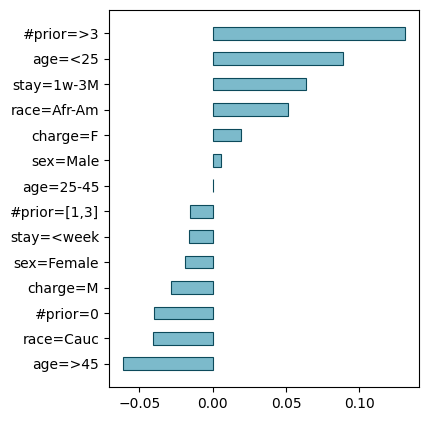

In [18]:
individual_divergence_fpr=fp_divergence_fpr.getFItemsetsDivergence()[1]
fp_divergence_fpr.plotShapleyValue(shapley_values=individual_divergence_fpr,sizeFig=(4,5))

## Global item divergence

We compute the global item divergence. 

In [19]:
global_item_divergence_fpr=fp_divergence_fpr.computeGlobalShapleyValue()

In [20]:
print(global_item_divergence_fpr)

{frozenset({'sex=Male'}): 0.0010817486715193343, frozenset({'stay=<week'}): -0.0037336591601187115, frozenset({'charge=F'}): 0.0033449442244256966, frozenset({'age=25-45'}): 2.646803546613426e-05, frozenset({'race=Afr-Am'}): 0.00868689049105502, frozenset({'#prior=[1,3]'}): -0.0019785581173622493, frozenset({'charge=M'}): -0.003826369756899656, frozenset({'race=Cauc'}): -0.006069980972847003, frozenset({'#prior=0'}): -0.0041045628972812016, frozenset({'#prior=>3'}): 0.012619810573522829, frozenset({'age=<25'}): 0.007341371481152314, frozenset({'age=>45'}): -0.004840017733268695, frozenset({'sex=Female'}): -0.0019292673088879431, frozenset({'stay=1w-3M'}): 0.006596700720581655}


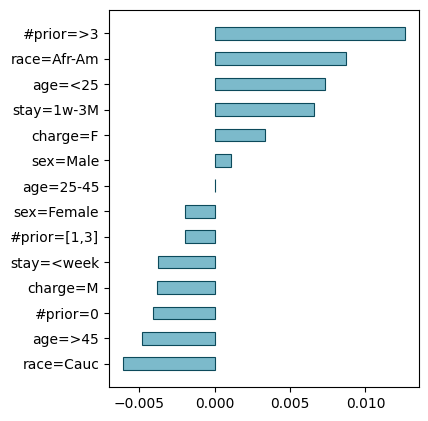

In [21]:
fp_divergence_fpr.plotShapleyValue(shapley_values=global_item_divergence_fpr,sizeFig=(4,5))

The number prior is the terms that mostly influences the FPR divergence. The race equal to Caucasian has instead a negative influence.

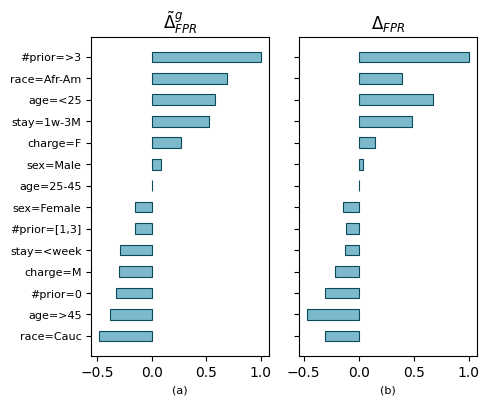

In [22]:
from divexplorer.shapley_value_FPx import compareShapleyValues, normalizeMax

compareShapleyValues(normalizeMax(global_item_divergence_fpr),\
                     normalizeMax(fp_divergence_fpr.getFItemsetsDivergence()[1]), \
                     title=[r"$\tilde{{Δ}}^g_{{FPR}}$", "$\Delta_{FPR}$"], \
                      labelsize=8, height=0.5, sizeFig=(5,4),\
                     subcaption=True)

We can, for visualization purposes, plot only the top K values in absolute terms.

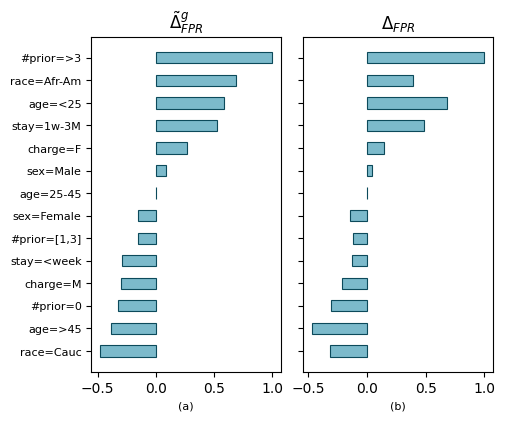

In [23]:
K=25
topK_global={k:v for k,v in global_item_divergence_fpr.items() if k in sorted(global_item_divergence_fpr, key=lambda x: abs(global_item_divergence_fpr[x]))[::-1][:K]}
topK_individual={k:v for k,v in fp_divergence_fpr.getFItemsetsDivergence()[1].items() if k in topK_global.keys()}

compareShapleyValues(normalizeMax(topK_global),\
                     normalizeMax(topK_individual), \
                     title=[r"$\tilde{{Δ}}^g_{{FPR}}$", "$\Delta_{FPR}$"], \
                      labelsize=8, height=0.5, sizeFig=(5,4),\
                     pad=0.5, subcaption=True)

We can proceed similarly for the analysis of the FNR divergence and accuracy divergence